In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('atp_transformed/2000-2024 players_3.csv')

C:\Users\Golbe\AppData\Local\Temp\ipykernel_27000\3553664543.py:1: DtypeWarning: Columns (18,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('atp_transformed/2000-2024 players_3.csv')


In [4]:
# make a copy of the player_table to visualise
median_df = df[['player_rank','elo_pre_match','days_of_experience','years_of_experience','months_of_experience','tourney_date','match_outcome','filled_player_rank','player_id','player_name']]

# Bin experience into 30-day intervals
median_df['days_bin'] = (median_df['days_of_experience'] // 30) * 30

median_df

C:\Users\Golbe\AppData\Local\Temp\ipykernel_27000\1091011350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  median_df['days_bin'] = (median_df['days_of_experience'] // 30) * 30


,player_rank,elo_pre_match,days_of_experience,years_of_experience,months_of_experience,tourney_date,match_outcome,filled_player_rank,player_id,player_name,days_bin
0,NaN,1500.000000,0,0.000000,0.000000,1969-03-17,1,2268.0,100001,Gardnar Mulloy,0
1,NaN,1515.966092,16,0.043806,0.525624,1969-04-02,1,2268.0,100001,Gardnar Mulloy,0
2,NaN,1531.231343,373,1.021218,12.253614,1970-03-25,1,2268.0,100001,Gardnar Mulloy,360
3,NaN,1500.000000,0,0.000000,0.000000,1971-05-31,1,2268.0,100003,Frank Sedgman,0
4,NaN,1515.329690,189,0.517454,6.208936,1971-12-06,1,2268.0,100003,Frank Sedgman,180
...,...,...,...,...,...,...,...,...,...,...,...
1282802,1865.0,1464.471740,49,0.134155,1.609724,2024-12-09,0,1865.0,213496,Marc Saura Moragrega,30
1282803,NaN,1500.000000,0,0.000000,0.000000,2024-11-04,0,2268.0,213523,Milan Welte,0
1282804,NaN,1500.000000,0,0.000000,0.000000,2024-10-14,0,2268.0,213608,Moise Kouame,0
1282805,NaN,1500.000000,0,0.000000,0.000000,2024-10-28,0,2268.0,213626,Angel Veliz,0


In [5]:
# filter out certain players
#median_df = median_df[median_df['player_id'] != 104925]

# create the median rank
median_rank = median_df.groupby('days_bin').agg(
    median_rank=('player_rank', 'median'),
    median_elo=('elo_pre_match', 'median'),
    median_filled_rank=('filled_player_rank','median')
).reset_index()

median_rank

,days_bin,median_rank,median_elo,median_filled_rank
0,0,680.0,1500.000000,2268.0
1,30,950.0,1498.427606,1314.0
2,60,874.5,1496.816856,1225.0
3,90,822.0,1498.897711,1152.0
4,120,768.0,1503.086826,1001.0
...,...,...,...,...
340,16530,471.0,1771.763721,471.0
341,16560,469.0,1755.297013,469.0
342,16620,566.0,1728.696107,566.0
343,17100,NaN,1516.000000,2268.0


based on the following query:

    with max_rank as (
        select max(player_rank) as min_median_rank from df
        where player_id != 104925
        ), 
        final as (
        select days_of_experience, player_rank from df) 
    
    select min_median_rank, days_of_experience from max_rank 
    left join (
    select days_of_experience, player_rank from final
    ) as fin on fin.player_rank = max_rank.min_median_rank

In [6]:
min_median_rank = median_rank['median_rank'].min()
final = median_rank[['days_bin', 'median_rank']]
result = final[final['median_rank'] == min_median_rank].copy()
result = result.rename(columns={'days_bin':'days_of_experience','median_rank':'max_median_rank'})
result

,days_of_experience,max_median_rank
260,7800,64.0


This makes sense when looking at the graph below, but there is an strange area between 6000 and 7800 where there is a second climb following a decline.

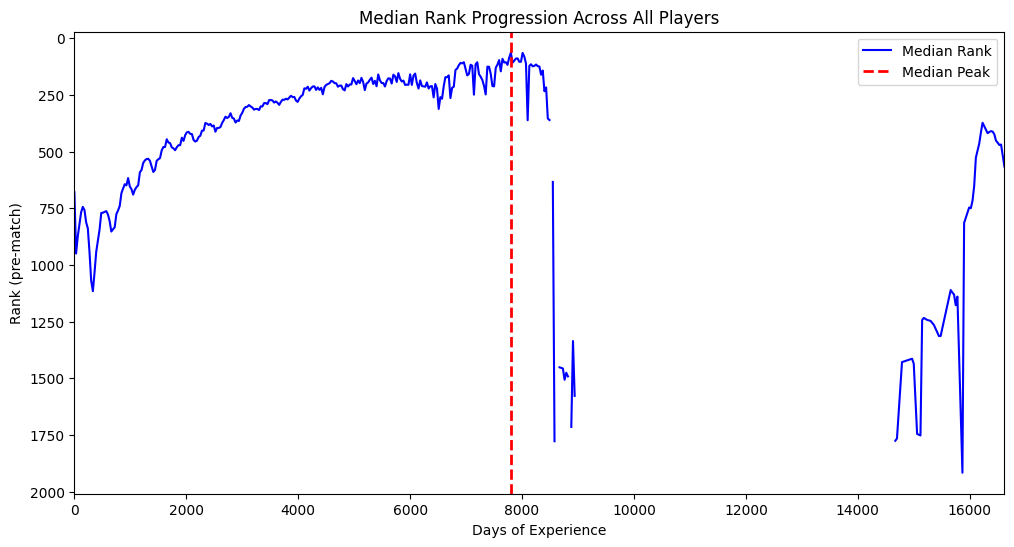

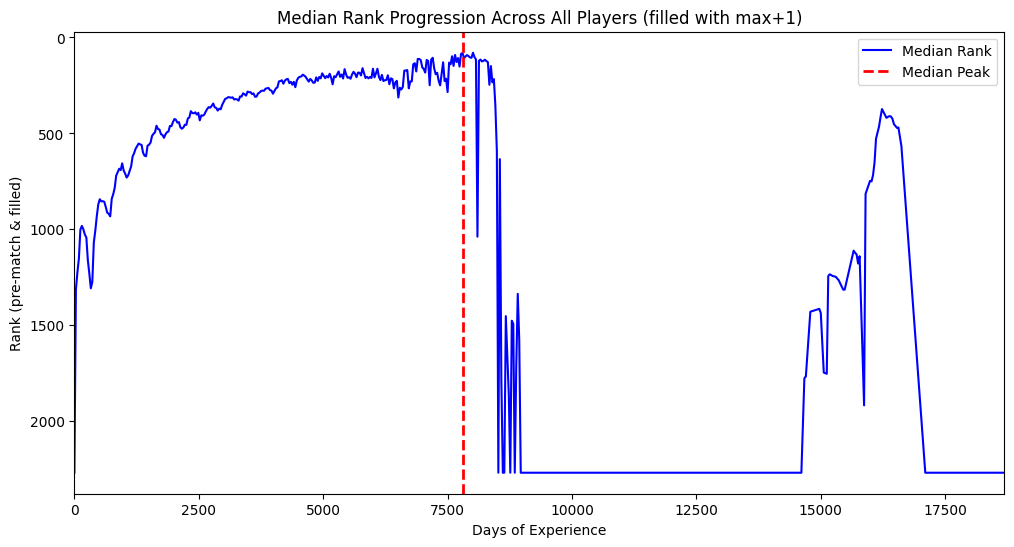

In [7]:
# filter away the later years sice they do not add much information
median_rank = median_rank#[median_rank['days_bin'] <= 8700]

plt.figure(figsize=(12,6))
plt.plot(median_rank['days_bin'], median_rank['median_rank'], color='blue', label='Median Rank')
plt.xlabel('Days of Experience')
plt.ylabel('Rank (pre-match)')
plt.title('Median Rank Progression Across All Players')
plt.axvline(x=7800, color='red', linestyle='--', linewidth=2, label='Median Peak')
plt.legend()
plt.margins(x=0)
plt.gca().invert_yaxis()

plt.figure(figsize=(12,6))
plt.plot(median_rank['days_bin'], median_rank['median_filled_rank'], color='blue', label='Median Rank')
plt.xlabel('Days of Experience')
plt.ylabel('Rank (pre-match & filled)')
plt.title('Median Rank Progression Across All Players (filled with max+1)')
plt.axvline(x=7800, color='red', linestyle='--', linewidth=2, label='Median Peak')
plt.legend()
plt.margins(x=0)
plt.gca().invert_yaxis()

In [8]:
# count unique player_ids
unique_players_per_bin = (
    median_df
    .groupby('days_bin')['player_id']
    .nunique()
    .reset_index(name='unique_player_count')
)

In [9]:
# create it as a percentage
total_players = median_df['player_id'].nunique()
unique_players_per_bin['percent_of_total_players'] = unique_players_per_bin['unique_player_count'] / total_players
unique_players_per_bin

,days_bin,unique_player_count,percent_of_total_players
0,0,19311,0.995515
1,30,2645,0.136354
2,60,2390,0.123209
3,90,2725,0.140478
4,120,2214,0.114135
...,...,...,...
340,16530,1,0.000052
341,16560,1,0.000052
342,16620,1,0.000052
343,17100,1,0.000052


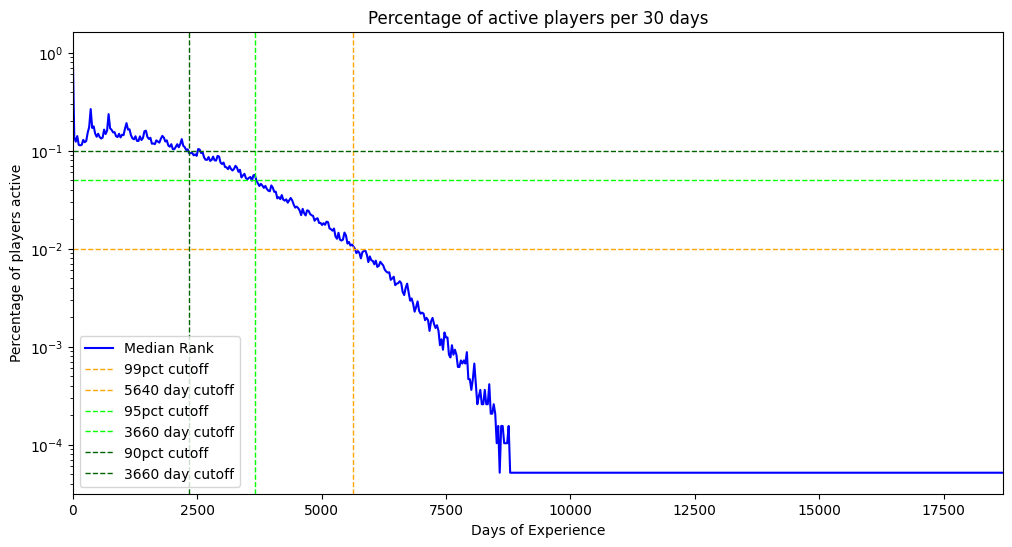

In [10]:
# Generally it's good practice to remove outliers which in normal distribution would usually mean at the 95 or 99% point.
# below a visualisation for this
unique_players_per_bin_excl_b1 = unique_players_per_bin

plt.figure(figsize=(12,6))
plt.plot(unique_players_per_bin_excl_b1['days_bin'], unique_players_per_bin_excl_b1['percent_of_total_players'], color='blue', label='Median Rank')
plt.xlabel('Days of Experience')
plt.ylabel('Percentage of players active')
plt.title('Percentage of active players per 30 days')
plt.yscale('log')
# 99%
plt.axhline(y=0.01, color='orange', linestyle='--', linewidth=1, label='99pct cutoff')
plt.axvline(x=5640, color='orange', linestyle='--', linewidth=1, label='5640 day cutoff')
# 95% 
plt.axhline(y=0.05, color='lime', linestyle='--', linewidth=1, label='95pct cutoff')
plt.axvline(x=3660, color='lime', linestyle='--', linewidth=1, label='3660 day cutoff')
# 90% 
plt.axhline(y=0.10, color='darkgreen', linestyle='--', linewidth=1, label='90pct cutoff')
plt.axvline(x=2340, color='darkgreen', linestyle='--', linewidth=1, label='3660 day cutoff')
plt.legend()
plt.margins(x=0)

If this is plotted on the previously seen player_rank graph

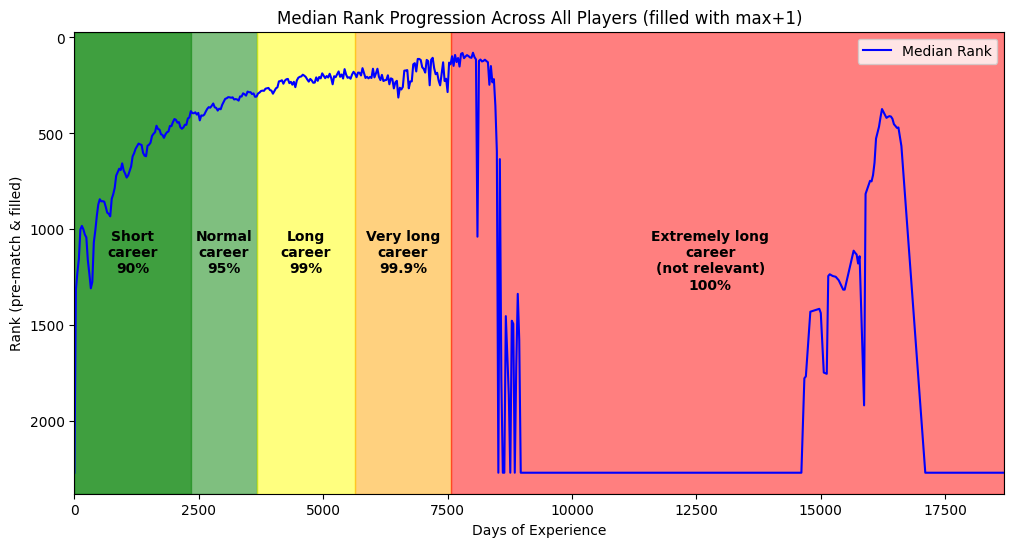

In [11]:
median_rank_filtered = median_rank

plt.figure(figsize=(12,6))
plt.plot(median_rank_filtered['days_bin'], median_rank_filtered['median_filled_rank'], color='blue', label='Median Rank')
plt.xlabel('Days of Experience')
plt.ylabel('Rank (pre-match & filled)')
plt.title('Median Rank Progression Across All Players (filled with max+1)')
plt.legend()
# 0-7 years (short career)
plt.axvspan(0, 2340, color='green', alpha=0.50)
plt.text(1170, 1000, 'Short\ncareer\n90%', ha='center', va='top', fontsize=10, color='black', fontweight='bold')
# 0-10 years (normal-ish career)
plt.axvspan(0, 3660, color='green', alpha=0.50)
plt.text(3000, 1000, 'Normal\ncareer\n95%', ha='center', va='top', fontsize=10, color='black', fontweight='bold')
# 10-15 years (long career)
plt.axvspan(3660, 5640, color='yellow', alpha=0.50)
plt.text(4650, 1000, 'Long\ncareer\n99%', ha='center', va='top', fontsize=10, color='black', fontweight='bold')
# 15-22 years (very long career)
plt.axvspan(5640, 7560, color='orange', alpha=0.50)
plt.text(6600, 1000, 'Very long\ncareer\n99.9%', ha='center', va='top', fontsize=10, color='black', fontweight='bold')
# 22+ years (unicorn career)
plt.axvspan(7560, median_rank_filtered['days_bin'].max(), color='red', alpha=0.50)
plt.text(12780, 1000, 'Extremely long\ncareer\n(not relevant)\n100%', ha='center', va='top', fontsize=10, color='black', fontweight='bold')
plt.margins(x=0)
plt.gca().invert_yaxis()

This means that anything past 7560 is not worth looking at and even the groups above 95% (3640-5640,5640-7560 days) might also be slightly suspect to use because of survivorship bias (good players keep playing for longer; boosting the player_rank artificially)

Let's compute the median peak per range

In [12]:
def get_peak_in_range(df, max_days,group_name=np.nan):
    """
    Returns the row(s) corresponding to the minimum median_rank 
    for days_bin <= max_days, with standardized column names.
    """
    subset = df[df['days_bin'] <= max_days]
    min_rank = subset['median_rank'].min()
    
    # Select rows where median_rank equals the minimum
    result = subset[subset['median_rank'] == min_rank][['days_bin', 'median_rank']].copy()

    result['group'] = group_name
    
    # Rename columns consistently
    result = result.rename(columns={'days_bin':'days_of_experience',
                                    'median_rank':'max_median_rank'})
    return result

short_peaks_result = get_peak_in_range(median_rank, 2340,'short')
normal_peaks_result = get_peak_in_range(median_rank, 3660,'normal')
long_peaks_result = get_peak_in_range(median_rank, 5640,'long')
very_long_peaks_result = get_peak_in_range(median_rank, 7560,'very long')

full_median_peak_results = pd.concat([short_peaks_result,normal_peaks_result,long_peaks_result,very_long_peaks_result],axis=0)
full_median_peak_results

,days_of_experience,max_median_rank,group
78,2340,374.0,short
116,3480,273.0,normal
117,3510,273.0,normal
181,5430,160.0,long
232,6960,106.0,very long
240,7200,106.0,very long


In [36]:
# create subset
num_df = df[['draw_size', 'match_num', 'minutes', 'player_seed', 'player_height', 'player_age', 'ace', 'double_faults', 'points_on_serve', 'first_serve_in', '1stWon', '2ndWon', 'service_games', 
             'break_points_saved', 'break_points_faced', 'player_rank', 'player_rank_points', 'elo_pre_match', 'match_outcome', 'opponent_id', 'opponent_elo_pre_match', 'opponent_rank', 'elo_post_match', 
             'round_1_numb', 'round_1_tb_numb', 'round_2_numb', 'round_2_tb_numb', 'round_3_numb', 'round_3_tb_numb', 'round_4_numb', 'round_4_tb_numb', 'round_5_numb', 'round_5_tb_numb', 
             'round_1_diff', 'round_1_tb_diff', 'round_2_diff', 'round_2_tb_diff', 'round_3_diff', 'round_3_tb_diff', 'round_4_diff', 'round_4_tb_diff', 'round_5_diff', 'round_5_tb_diff', 
             'mean_numb', 'median_numb', 'total_numb', 
             'mean_diff', 'median_diff', 'total_diff', 
             'mean_tb_numb', 'median_tb_numb', 'total_tb_numb', 
             'mean_tb_diff', 'median_tb_diff', 'total_tb_diff', 
             'days_of_experience', 'months_of_experience', 'years_of_experience', 'career_year', 'rest_days',  
             'sets_won', 'sets_lost', 
             'tb_sets_won', 'tb_sets_lost', 
             'set_dominance', 'tb_dominance', 
             'highest_finish_position', 
             'minutes_rolling_med_10', 'draw_size_rolling_med_10', 'finish_position_rolling_med_10', 'highest_finish_position_rolling_med_10', 'ace_rolling_mean_10', 'double_faults_rolling_mean_10', 
             'points_on_serve_rolling_mean_10', 'first_serve_in_rolling_mean_10', '1stWon_rolling_mean_10', '2ndWon_rolling_mean_10', 'service_games_rolling_mean_10', 
             'break_points_saved_rolling_mean_10', 'break_points_faced_rolling_mean_10', 
             'elo_pre_match_rolling_mean_10', 'opponent_elo_pre_match_rolling_mean_10', 
             'set_dominance_rolling_mean_10', 'tb_dominance_rolling_mean_10', 
             'player_rank_rolling_mean_10', 
             'mean_numb_rolling_mean_10', 'median_numb_rolling_mean_10', 'total_numb_rolling_mean_10', 
             'mean_diff_rolling_mean_10', 'median_diff_rolling_mean_10', 'total_diff_rolling_mean_10', 
             'mean_tb_numb_rolling_mean_10', 'median_tb_numb_rolling_mean_10', 'total_tb_numb_rolling_mean_10', 
             'mean_tb_diff_rolling_mean_10', 'median_tb_diff_rolling_mean_10', 'total_tb_diff_rolling_mean_10', 
             'elo_next_match', 'filled_player_rank']]

# and make sure that the subset is filtered for a certain time period
# eligible cutoff points for days_of_experience = [2340, 3660, 5640, 7560]
num_df = num_df[num_df['days_of_experience'] <= 3660]

In [37]:
pearson_correlation = num_df.corr('pearson')

In [ ]:
abs(pearson_correlation[
    [
        'filled_player_rank',
        #'player_rank'
        ]]).sort_values(by='filled_player_rank',ascending=False)

,filled_player_rank
player_rank,1.000000
filled_player_rank,1.000000
player_rank_rolling_mean_10,0.916559
highest_finish_position_rolling_med_10,0.409303
opponent_rank,0.379846
...,...
opponent_elo_pre_match_rolling_mean_10,0.511861
elo_pre_match_rolling_mean_10,0.674279
elo_pre_match,0.679020
elo_next_match,0.680410
